# EMT Model Trainer
### Author: Joel Meoak
### This notebook is used to train new models for use with the EMT framework

In [4]:
import ember
from joblib import dump, load
import pandas as pd
import re
import numpy as np

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LeakyReLU, Dropout, Flatten, Conv1D
from keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.random import set_seed
from tensorflow.keras.losses import CategoricalCrossentropy

## Data Preparation

In [5]:
X_train, y_train, X_test, y_test = ember.read_vectorized_features(r"C:\Users\joelm\anaconda3\A_Working\ember2018\ember2018")
metadata_dataframe = ember.read_metadata(r"C:\Users\joelm\anaconda3\A_Working\ember2018\ember2018")

In [6]:
X_train_pd = pd.DataFrame(data=X_train, copy=True)
y_train_pd = pd.DataFrame(data=y_train, copy=True)
X_test_pd = pd.DataFrame(data=X_test, copy=True)
y_test_pd = pd.DataFrame(data=y_test, copy=True)

Data is labeled 1 = malware, 0 = benign, -1 = unclassified

In this case, we are using a supervised models for classification so unclassified training data needs to be removed

In [7]:
filtered_x_df = X_train_pd[y_train_pd[0]!=-1]

In [8]:
filtered_x_df.shape

(600000, 2381)

In [9]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 2500)
pd.set_option('display.width', 2500)

In [10]:
filtered_y_df = y_train_pd[y_train_pd[0]!=-1]

In [11]:
filtered_y_df.shape

(600000, 1)

In [12]:
filtered_y_df.value_counts()

0.0    300000
1.0    300000
Name: count, dtype: int64

In [13]:
# Notable is the large memory space for this dataset
filtered_x_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 0 to 799999
Columns: 2381 entries, 0 to 2380
dtypes: float32(2381)
memory usage: 5.3 GB


In [14]:
filtered_y_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 0 to 799999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       600000 non-null  float32
dtypes: float32(1)
memory usage: 6.9 MB


In [15]:
filtered_x_df.head()

0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54        55        56        57        58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88        89        90        91        92        93        94        95        96        97        98        99        100       101       102       103       104       105       106       107       108       109       110       111       112       113       114       115       116       117       118       119       120       121       122       123       124       125       126       127       128       129       130       131       132       133       134       135       136       137       138       139       140       141       142       143       144       145       146       147       148       149       150       151       152       153       154       155       156       157       158       159       160       161       162       163       164       165       166       167       168       169       170       171       172       173       174       175       176       177       178       179       180       181       182       183       184       185       186       187       188       189       190       191       192       193       194       195       196       197       198       199       200       201       202       203       204       205       206       207       208       209       210       211       212       213       214       215       216       217       218       219       220       221       222       223       224       225       226       227       228       229       230       231       232       233       234       235       236       237       238       239       240       241       242       243       244       245       246       247       248   \
0  0.014676  0.004222  0.003923  0.004029  0.004007  0.003775  0.003825  0.003887  0.004153  0.003804  0.003805  0.003799  0.003878  0.003895  0.003790  0.004040  0.003862  0.003749  0.003709  0.003777  0.003807  0.004002  0.003798  0.003775  0.003855  0.003747  0.003823  0.003796  0.003778  0.003710  0.003828  0.003798  0.003874  0.003769  0.003764  0.003799  0.003811  0.003823  0.003877  0.003800  0.003782  0.003690  0.003726  0.003764  0.003887  0.003751  0.003762  0.003838  0.003870  0.003785  0.003815  0.003975  0.003797  0.003823  0.003806  0.003735  0.003796  0.003832  0.003825  0.003884  0.003827  0.003894  0.003780  0.003881  0.004233  0.003847  0.003901  0.003934  0.003855  0.004070  0.003829  0.003806  0.003869  0.003827  0.003733  0.003737  0.003847  0.003875  0.003771  0.003841  0.004051  0.003790  0.003739  0.003941  0.003800  0.003775  0.003972  0.003974  0.003763  0.003748  0.003731  0.003830  0.003733  0.003805  0.003888  0.003802  0.003716  0.003949  0.003773  0.003802  0.003915  0.004095  0.003892  0.003827  0.004056  0.003980  0.003967  0.003834  0.003930  0.003872  0.003813  0.003953  0.003914  0.003841  0.003867  0.003919  0.004199  0.004235  0.003836  0.003922  0.003942  0.003860  0.003842  0.003853  0.003889  0.003947  0.003872  0.003955  0.004080  0.003876  0.003810  0.003960  0.003831  0.003967  0.003789  0.003833  0.003861  0.004021  0.003747  0.004275  0.003859  0.003910  0.003783  0.003877  0.003737  0.003772  0.003741  0.003758  0.003860  0.003777  0.003842 

In [ ]:
# Function to count dll count in original json files of dataset
jsonl_file_path = 'train_features_5.jsonl'

pattern = r'"exports": 0'
pattern2 = r'"label": (?<!-1)\b-?\d+\b'

# Initialize a variable to count matches
num_matches = 0

# Read the JSONL file line by line and count matches
with open(jsonl_file_path, 'r') as file:
    for line in file:
        # Search for the pattern in the line
        matches = re.findall(pattern, line)
        if matches != []:
            matches = re.findall(pattern2, line)
        # Increment the match count by the number of matches in this line
        num_matches += len(matches)

# Print the number of matches
print("Number of matches:", num_matches)

In [ ]:
total_dll = 12133 + 17013 + 13996 + 15207 + 13324 + 21065
total_exe = 37867 + 99038 + 79611 + 79106 + 83522 + 128118
print('Total DLL Count: ' + total_dll) 
print('Total exe Count: ' +total_exe)
print('Total Sample Count: ' +total_dll + total_exe)

In [93]:
# Create a sample weight column based on dll or exe
X_Weights = pd.DataFrame()
X_Weights['sample_weight'] = filtered_x_df[619].apply(lambda x: 5 if x != 0 else 1)

In [94]:
X_Weights['sample_weight']

0         1
1         1
2         1
3         1
4         1
         ..
799995    5
799996    5
799997    1
799998    5
799999    5
Name: sample_weight, Length: 600000, dtype: int64

# Traditional Models

## Light GBM Model training for benchmarking

In [ ]:
lgbm_model = lgb.Booster(model_file=r"C:\Users\joelm\anaconda3\A_Working\ember2018\ember2018\ember_model_2018.txt")

In [ ]:
dump(lgbm_model, 'lgbm.joblib')

## Sklearn Decision Tree Classifier

In [15]:
tree = DecisionTreeClassifier(random_state=0)

In [16]:
tree.fit(filtered_x_df, filtered_y_df)

DecisionTreeClassifier(random_state=0)

In [21]:
dump(tree, 'tree_basic_25Apr.joblib') 

['tree_basic_25Apr.joblib']

## Sklearn Random Forest Classifier

RF9 is the 9th version of the random forest classifier used. Gridsearches (Run in a stand alone notebook
due to runtime considerations and included below in text form) were conducted across bootstrap, max_depth, min_samples_split, min_samples_leaf, criterion, and max_features.  The changes from default configuration based on that gridsearches were changing min_samples_split=2 and bootstrap=False. Additionally, testing showed minimal change in accuracy going from 100 estimators to 25 with drastic changes in training time. 


In [ ]:
text_representation = tree.export_text(tree_new)
print(text_representation)

In [89]:
# Primary RF Model
rf9 = RandomForestClassifier(random_state=42, bootstrap=False, n_estimators=25, min_samples_split=2)

In [34]:
rf9.fit(filtered_x_df, filtered_y_df)

C:\Users\joelm\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(bootstrap=False, n_estimators=25, random_state=42)

In [ ]:
dump(rf9, 'RF9.joblib') 

In [ ]:
# Model Turned to DLLs
rf9_dll = RandomForestClassifier(random_state=42, bootstrap=False, n_estimators=25, min_samples_split=2)

In [ ]:
rf9_dll.fit(filtered_x_df, filtered_y_df, sample_weight=X_Weights['sample_weight'])

In [ ]:
dump(rf9_dll, 'RF9_dll.joblib') 

## Sklearn Extremely Random Forest Classifier


In [86]:
et = ExtraTreesClassifier(n_jobs=-1,random_state=42, n_estimators=25)

In [87]:
et.fit(filtered_x_df, filtered_y_df)

C:\Users\joelm\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ExtraTreesClassifier(n_estimators=25, n_jobs=-1, random_state=42)

In [90]:
dump(et, 'ET1.joblib') 

['ET1.joblib']

In [96]:
et_dll = ExtraTreesClassifier(n_jobs=-1,random_state=42, n_estimators=25)

In [97]:
et_dll.fit(filtered_x_df, filtered_y_df, sample_weight=X_Weights['sample_weight'])

C:\Users\joelm\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ExtraTreesClassifier(n_estimators=25, n_jobs=-1, random_state=42)

In [98]:
dump(et_dll, 'ET1_DLL.joblib') 

['ET1_DLL.joblib']

## Sklearn Logistic Regression

In [128]:
lr_model = LogisticRegression()

In [129]:
lr_model.fit(filtered_x_df, filtered_y_df)

C:\Users\joelm\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\joelm\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [130]:
dump(lr_model, 'LR1.joblib')

['LR1.joblib']

## Sklearn Gradient Boosting Classifer

In [126]:
gbc = GradientBoostingClassifier(n_estimators=25, learning_rate=1.0, random_state=42)

In [106]:
gbc.fit(filtered_x_df, filtered_y_df)

C:\Users\joelm\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=1.0, n_estimators=25, random_state=42)

In [108]:
dump(gbc, 'gbc1_rf9.joblib')

['gbc1_rf9.joblib']

## Sklearn AdaBoost Classifier with a Random Forest Classifer

In [131]:
rfboost = RandomForestClassifier(random_state=42, bootstrap=False, n_estimators=25, min_samples_split=2)

adaboost_clf = AdaBoostClassifier(
    estimator=rfboost,
    n_estimators=25,
    algorithm="SAMME",
    random_state=42,
)

In [132]:
adaboost_clf.fit(filtered_x_df, filtered_y_df)

C:\Users\joelm\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME',
                   estimator=RandomForestClassifier(bootstrap=False,
                                                    n_estimators=25,
                                                    random_state=42),
                   n_estimators=25, random_state=42)

In [133]:
dump(adaboost_clf, 'ADB_RF9.joblib')

['ADB_RF9.joblib']

# Neural Networks

## Tensor Flow Keras Squential with 8 Dense layers, adam optimizer, and 128 epochs

In [18]:
model_seq = tf.keras.Sequential()
model_seq.add(tf.keras.Input(shape=(2381,)))
model_seq.add(tf.keras.layers.Dense(64))
model_seq.add(tf.keras.layers.Dense(64))
model_seq.add(tf.keras.layers.Dense(32))
model_seq.add(tf.keras.layers.Dense(16))
model_seq.add(tf.keras.layers.Dense(8))
model_seq.add(tf.keras.layers.Dense(4))
model_seq.add(tf.keras.layers.Dense(2))
model_seq.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
model_seq.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_seq.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │       152,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,401 (622.66 KB)

 Trainable params: 159,401 (622.66 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model_seq_fitted = model_seq.fit(filtered_x_df, filtered_y_df, batch_size=128, epochs=128, validation_data=(X_test_pd, y_test_pd))

Epoch 1/128
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - binary_accuracy: 0.5245 - loss: 696373.3750 - val_binary_accuracy: 0.5391 - val_loss: 4784.9399
Epoch 2/128
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - binary_accuracy: 0.5362 - loss: 3410.9268 - val_binary_accuracy: 0.6032 - val_loss: 109.6360
Epoch 3/128
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - binary_accuracy: 0.5533 - loss: 737.2799 - val_binary_accuracy: 0.5336 - val_loss: 1071.7256
Epoch 4/128
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - binary_accuracy: 0.5608 - loss: 871.7322 - val_binary_accuracy: 0.5672 - val_loss: 21.7144
Epoch 5/128
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - binary_accuracy: 0.5556 - loss: 1268.1399 - val_binary_accuracy: 0.6025 - val_loss: 41.7314
Epoch 6/128
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - binary_accuracy: 0.5688 - loss: 276.4347 - val_binary_accuracy: 0.5949 - val_loss: 11.4594
Epoch 7/128
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - binary_accuracy: 0.5779 - loss: 52.8514 - 

In [61]:
dump(model_seq, 'SeqNN_8D_128E.joblib') 

['SeqNN_8D_128E.joblib']

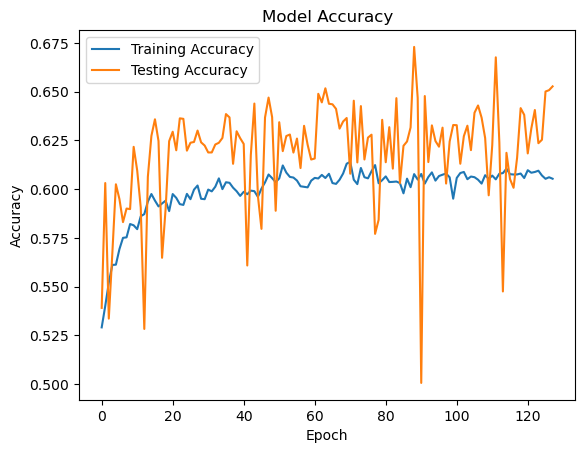

In [50]:
plt.plot(model_seq_fitted.history['binary_accuracy'])
plt.plot(model_seq_fitted.history['val_binary_accuracy'])
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper left')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

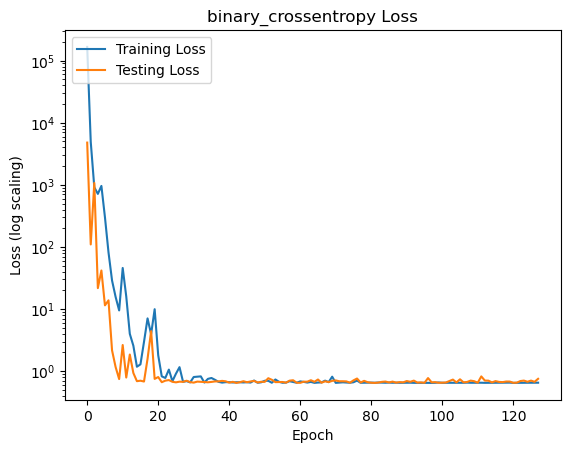

In [54]:
plt.plot(model_seq_fitted.history['loss'])
plt.plot(model_seq_fitted.history['val_loss'])
plt.legend(['Training Loss', 'Testing Loss'], loc='upper left')
plt.title('binary_crossentropy Loss')
plt.ylabel('Loss (log scaling)')
plt.xlabel('Epoch')
plt.yscale('log')
plt.show()

## Tensor Flow Keras Squential with 9 Dense layers, SGD optimizer, and 32 epochs

In [57]:
model_seq_2 = tf.keras.Sequential()
model_seq_2.add(tf.keras.Input(shape=(2381,)))
model_seq_2.add(tf.keras.layers.Dense(256))
model_seq_2.add(tf.keras.layers.Dense(128))
model_seq_2.add(tf.keras.layers.Dense(64))
model_seq_2.add(tf.keras.layers.Dense(32))
model_seq_2.add(tf.keras.layers.Dense(16))
model_seq_2.add(tf.keras.layers.Dense(8))
model_seq_2.add(tf.keras.layers.Dense(4))
model_seq_2.add(tf.keras.layers.Dense(2))
model_seq_2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
model_seq_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_seq_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 256)            │       609,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653,737 (2.49 MB)

 Trainable params: 653,737 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model_seq_2_fitted = model_seq_2.fit(filtered_x_df, filtered_y_df, batch_size=128, epochs=32, validation_data=(X_test_pd, y_test_pd))

Epoch 1/32
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - binary_accuracy: 0.5325 - loss: 2314435.5000 - val_binary_accuracy: 0.5793 - val_loss: 804.2976
Epoch 2/32
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - binary_accuracy: 0.5489 - loss: 24266.0996 - val_binary_accuracy: 0.5776 - val_loss: 625.7994
Epoch 3/32
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - binary_accuracy: 0.5525 - loss: 7497.4238 - val_binary_accuracy: 0.6110 - val_loss: 77.5327
Epoch 4/32
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - binary_accuracy: 0.5595 - loss: 596.8910 - val_binary_accuracy: 0.5621 - val_loss: 96.3448
Epoch 5/32
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - binary_accuracy: 0.5592 - loss: 754.2319 - val_binary_accuracy: 0.5907 - val_loss: 502.2676
Epoch 6/32
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - binary_accuracy: 0.5626 - loss: 1065.7565 - val_binary_accuracy: 0.6487 - val_loss: 11.7848
Epoch 7/32
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - binary_accuracy: 0.5702 - loss: 554.9566 - v

In [62]:
dump(model_seq_2, 'SeqNN_9D_32E.joblib') 

['SeqNN_9D_32E.joblib']

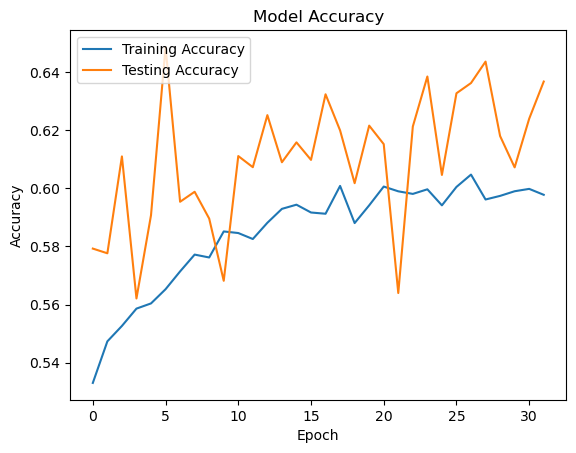

In [63]:
plt.plot(model_seq_2_fitted.history['binary_accuracy'])
plt.plot(model_seq_2_fitted.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper left')
plt.show()

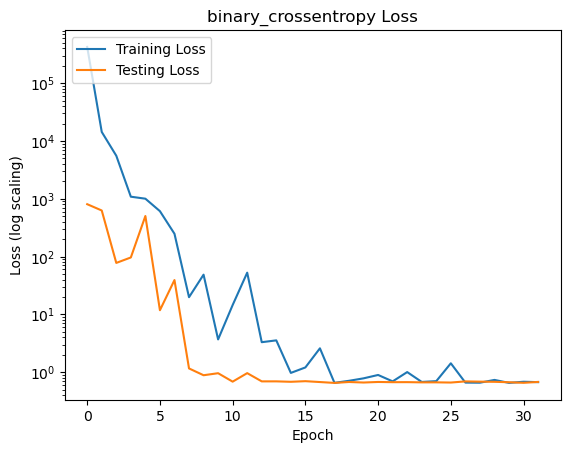

In [64]:
plt.plot(model_seq_2_fitted.history['loss'])
plt.plot(model_seq_2_fitted.history['val_loss'])
plt.legend(['Training Loss', 'Testing Loss'], loc='upper left')
plt.title('binary_crossentropy Loss')
plt.ylabel('Loss (log scaling)')
plt.xlabel('Epoch')
plt.yscale('log')
plt.show()

## Tensor Flow Convolutional Neural Network

In [74]:
model_conv = Sequential()
model_conv.add(tf.keras.Input(shape=(2381,1)))
model_conv.add(Conv1D(filters=64, kernel_size=8, activation='relu')) 
model_conv.add(Flatten())
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_conv.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 2374, 64)       │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 151936)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │       151,937 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,513 (595.75 KB)

 Trainable params: 152,513 (595.75 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
model_conv_fitted = model_conv.fit(filtered_x_df, filtered_y_df, batch_size=128, epochs=10, validation_data=(X_test_pd, y_test_pd))

Epoch 1/10
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 307s 65ms/step - binary_accuracy: 0.5481 - loss: 488189.4375 - val_binary_accuracy: 0.5446 - val_loss: 60634.8906
Epoch 2/10
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 299s 64ms/step - binary_accuracy: 0.5947 - loss: 11349.6953 - val_binary_accuracy: 0.6532 - val_loss: 2418.6562
Epoch 3/10
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 307s 66ms/step - binary_accuracy: 0.6102 - loss: 5854.5938 - val_binary_accuracy: 0.5840 - val_loss: 8990.4033
Epoch 4/10
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 297s 63ms/step - binary_accuracy: 0.6128 - loss: 7470.7808 - val_binary_accuracy: 0.5081 - val_loss: 31385.4746
Epoch 5/10
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 291s 62ms/step - binary_accuracy: 0.5427 - loss: 56696.2188 - val_binary_accuracy: 0.6381 - val_loss: 5162.4956
Epoch 6/10
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 294s 63ms/step - binary_accuracy: 0.6346 - loss: 8083.2656 - val_binary_accuracy: 0.6577 - val_loss: 5111.3623
Epoch 7/10
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 299s 64ms/step - binary_accuracy: 

In [76]:
dump(model_conv, 'ConvNN.joblib') 

['ConvNN.joblib']

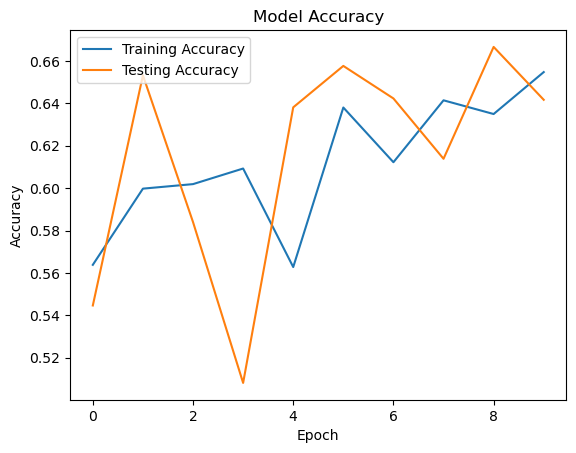

In [79]:
plt.plot(model_conv_fitted.history['binary_accuracy'])
plt.plot(model_conv_fitted.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper left')
plt.show()

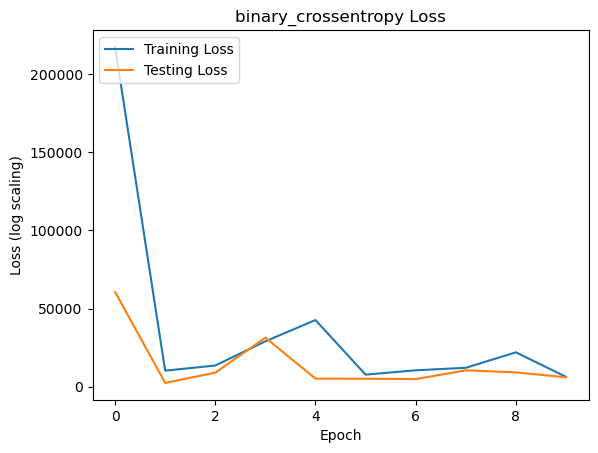

In [80]:
plt.plot(model_conv_fitted.history['loss'])
plt.plot(model_conv_fitted.history['val_loss'])
plt.legend(['Training Loss', 'Testing Loss'], loc='upper left')
plt.title('binary_crossentropy Loss')
plt.ylabel('Loss (log scaling)')
plt.xlabel('Epoch')
plt.show()

## Tensor Flow Simple Recurrent Neural Network

This model started with a relatively high accuracy but completely fell off. Will not be used in framework

In [16]:
model = Sequential()
model.add(tf.keras.Input(shape=(2381,1)))

model.add(SimpleRNN(units=64))
model.add(LeakyReLU(negative_slope=0.3))
model.add(Dropout(rate=0.2))

model.add(Dense(units=1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(filtered_x_df, filtered_y_df, batch_size=512, epochs=10, validation_data=(X_test_pd, y_test_pd))

Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1008s 859ms/step - accuracy: 0.6044 - loss: 0.6549 - val_accuracy: 0.6441 - val_loss: 0.6099
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1023s 873ms/step - accuracy: 0.6139 - loss: 0.6424 - val_accuracy: 0.6434 - val_loss: 0.6089
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 968s 826ms/step - accuracy: 0.6276 - loss: 0.6323 - val_accuracy: 0.6410 - val_loss: 0.6111
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 998s 851ms/step - accuracy: 0.6287 - loss: 0.6250 - val_accuracy: 0.6417 - val_loss: 0.6088
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1033s 882ms/step - accuracy: 0.6301 - loss: 0.6242 - val_accuracy: 0.6417 - val_loss: 0.6090
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1016s 867ms/step - accuracy: 0.6319 - loss: 0.6234 - val_accuracy: 0.6417 - val_loss: 0.6069
Epoch 7/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1027s 877ms/step - accuracy: 0.6323 - loss: 0.6232 - val_accuracy: 0.6436 - val_loss: 0.6097
Epoch 8/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1079s 921ms/ste

In [18]:
dump(model, 'SimpleRNN_1.joblib') 

['SimpleRNN_1.joblib']

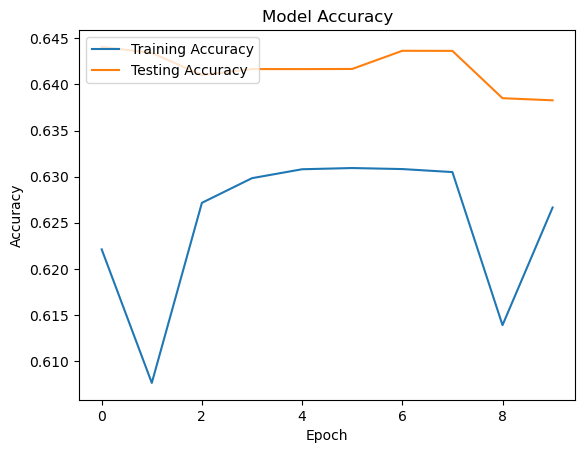

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper left')
plt.show()

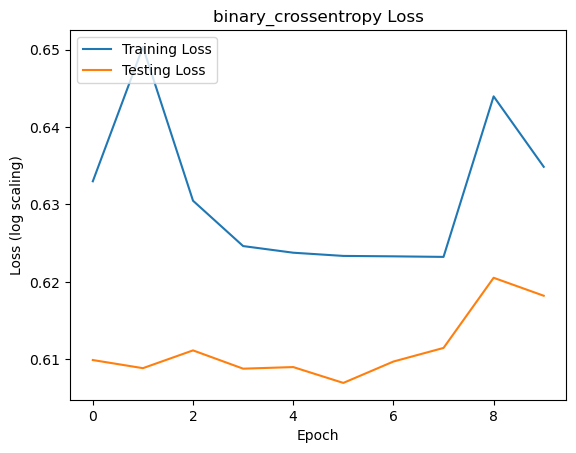

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Testing Loss'], loc='upper left')
plt.title('binary_crossentropy Loss')
plt.ylabel('Loss (log scaling)')
plt.xlabel('Epoch')
plt.show()